# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №1 - Метод k-средних, предобработка признаков


# <hr\>
**Общая информация**

**Срок сдачи:** до 7 октября 2017, 06:00   
**Штраф за опоздание:** -2 балла после 06:00 7 октября, -4 балла после 06:00 14 октября, -6 баллов после 06:00 21 октября

При отправлении ДЗ указывайте фамилию в названии файла   


Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush
Необходимо в slack создать таск в приватный чат:   
/todo Фамилия Имя *ссылка на гитхаб* @alkhamush   
Пример:   
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush   

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

# Первое задание - указать фамилию в имени файла

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Пролог: Модуль sklearn
На наших практических занятиях мы будем использовать [sklearn](http://scikit-learn.org/stable/index.html) (scikit-learn) - наиболее популярный модуль для работы с методами машинного обучения и анализа данных.

Этот модуль регулярно обновляется, расширяется и сопровождается примерами использования тех или иных методов. Помимо самих алгоритмов (например k-средних или линейной регрессии) в нем есть множество вспомогательных функций по работе с данными.

# Туториал: Работа с различными типами признаков

Вспомним какие типы признаков могут встретится при описании объектов исследования и как их представить в доступной для обработки компьтером форме

Типы признаков мы будем рассматривать на примере довольно популярного набора данных [titanic](https://www.kaggle.com/c/titanic/download/train.csv) - информации о выживаемости пассажиров после известной трагедии корабля Titanic.

In [63]:
df_titanic = pd.read_csv('train.csv', sep=',').dropna()
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


## Бинарные признаки
Это признаки с двумя возможными значениями
* Пол (мужской, женский)
* Выжил (да, нет)

На вход в алгоритмы обычно подаются в виде значений `{0, 1}` (реже в виде `{-1, 1}`)

In [64]:
# Здесь все нормально
df_titanic.Survived.value_counts()

1    123
0     60
Name: Survived, dtype: int64

In [65]:
# Тут стоит выполнить переобознаение
df_titanic.Sex.value_counts()

male      95
female    88
Name: Sex, dtype: int64

In [66]:
# Например так
df_titanic.Sex = df_titanic.Sex.replace({'male': 0, 'female': 1})
df_titanic.Sex.value_counts()

0    95
1    88
Name: Sex, dtype: int64

## Вещественные признаки

* Возраст
* Сумма, потраченная на билет
* Количество родственников на борту

Как правило остаются в том же виде или выполняется **нормализация** признаков, т.е. переход к одинаковой шкале, например:

* $\tilde{x} = \frac{x - \text{mean}(x)}{\text{std}(x)}$
* $\tilde{x} = \frac{x - \text{min}(x)}{\text{max}(x) - \text{min}(x)}$

## Категориальные признаки

Принимают значения из *неупорядоченного* множества

* Порт погрузки (C = Cherbourg; Q = Queenstown; S = Southampton)
* Точка отправления (St Louis, MO; Montreal, PQ; .. }
* Точка назначения (Chesterville, ON; Roseville, IL; .. }

Обычно такие признаки кодируют с помощью так называемого One Hot Encoding: </br>
для каждой категории создается бинарная маска-столбец, в которой стоит `1` если значение признака равно значению соответствующей категории категории.

Например, для признака "порт погрзки" создается бинарная макска из трех стобцов для каждого из портов: С, Q, S<br/>
Если пассажир заходил на кораблю в порту Southampton, то его признаковое описание будет соответственно: `[0, 0, 1]`

In [67]:
df_titanic.Embarked.head()

1     C
3     S
6     S
10    S
11    S
Name: Embarked, dtype: object

In [68]:
# Сделать в python это можно несколькими способами:

# 1: Через pandas (не очень рекомендуется)
emb = pd.get_dummies(df_titanic.Embarked, prefix='Embarked', prefix_sep='=')
emb.head()

,Embarked=C,Embarked=Q,Embarked=S
1,1,0,0
3,0,0,1
6,0,0,1
10,0,0,1
11,0,0,1


In [69]:
# 2: Функционал sklearn
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)

emb = df_titanic.loc[:, ['Embarked']].replace({'C': 0, 'Q': 1, 'S': 2}).values
emb_enc = encoder.fit_transform(emb)
emb_enc[:5]

array([[ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.]])

Про другием способы работы с категориальными переменными можно прочитать вот [тут](https://alexanderdyakonov.wordpress.com/2016/08/03/python-%D0%BA%D0%B0%D1%82%D0%B5%D0%B3%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5-%D0%BF%D1%80%D0%B8%D0%B7%D0%BD%D0%B0%D0%BA%D0%B8/)

## Порядковый признаки

Принимают значения из *упорядоченного* множества

* Класс каюты (1 > 2 > 3)

В зависимости от метода остаются можно оставить в исходном виде или применить OneHotEncoding.

## Текстовые признаки - Bag of words

Для демонстрации возьмем текст стихотворения Блока:

Ночь, улица, фонарь, аптека,<br/>
Бессмысленный и тусклый свет.<br/>
Живи еще хоть четверть века -<br/>
Все будет так. Исхода нет.<br/>

Умрешь - начнешь опять сначала<br/>
И повторится все, как встарь:<br/>
Ночь, ледяная рябь канала,<br/>
Аптека, улица, фонарь.<br/>

Пусть каждая строчка - это будет условный документ. Переведем эти документы в числовое представление по методу мешка слов (Bag Of Words)

In [70]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = \
[u'Ночь, улица, фонарь, аптека,',
 u'Бессмысленный и тусклый свет.',
 u'Живи еще хоть четверть века -',
 u'Все будет так. Исхода нет.',
 u'Умрешь - начнешь опять сначала',
 u'И повторится все, как встарь:',
 u'Ночь, ледяная рябь канала,',
 u'Аптека, улица, фонарь.']

In [71]:
vect = CountVectorizer()

bow = vect.fit_transform(corpus)
bow = bow.toarray()
bow.shape

(8L, 27L)

Получили матрицу размера $8 \times 27$, так как у нас 8 строчек и выделилось 27 униальных слов. Элемент матрицы показывает сколько раз слово встречалось в соответствующем документе.

In [72]:
bow

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1],
       [0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0]], dtype=int64)

In [73]:
# Посмотрим какие слова стоят по столбцам
for i, w in enumerate(vect.get_feature_names()):
    print u'столбец %d: %s' % (i, w)

столбец 0: аптека
столбец 1: бессмысленный
столбец 2: будет
столбец 3: века
столбец 4: все
столбец 5: встарь
столбец 6: еще
столбец 7: живи
столбец 8: исхода
столбец 9: как
столбец 10: канала
столбец 11: ледяная
столбец 12: начнешь
столбец 13: нет
столбец 14: ночь
столбец 15: опять
столбец 16: повторится
столбец 17: рябь
столбец 18: свет
столбец 19: сначала
столбец 20: так
столбец 21: тусклый
столбец 22: улица
столбец 23: умрешь
столбец 24: фонарь
столбец 25: хоть
столбец 26: четверть


# Туториал: Имплементация собственного метода

Для решения задач вида "имплементируйте метод X" крайне желательно (но необязательно) реализовывать методы с помощью интерфейса sklearn. Ниже вы увидите пример очень простого **классификатора**. Используйте эти наработи для выполнения задания.

Загрузите [датасет](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) с информацией о характеристиках вина и его качестве. (В метод `pd.read_csv()` можно подать веб-ссылку на данные и пандас их скачает и преобразует в `DataFrame`).

In [74]:
df_wine = pd.read_csv('winequality-red.csv', sep=';')

In [75]:
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Наша задача состоит в предсказании целевого признака `quality` по остальным признакам. `quality` - это вещественная переменная (оценка качества от 0 до 10). Упростим себе задачу - создадим новый столбец `quality_cat` по следующим правилам:

* `quality_cat = 1` если `quality > 5` 
* `quality_cat = 0` - иначе 

Таким образом, `quality_cat` характерует "плохое" и "хорошее" вино.

In [76]:
def prepocess_wine(df):
    df.loc[:, 'quality_cat'] = (df.loc[:, 'quality'] > 5).astype(int)
    df = df.drop('quality', axis=1)
    
    return df

In [77]:
df_wine = df_wine.pipe(prepocess_wine)
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_cat
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


Нарисуем распределение хорошего и плохого вина по признаку `alcohol`.

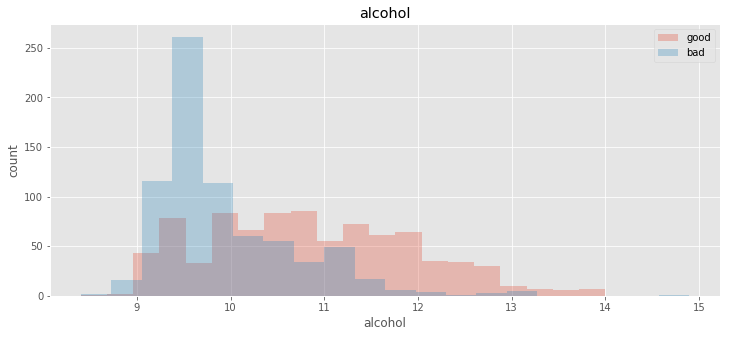

In [80]:
_, ax = plt.subplots(1,1)
df_wine.query('quality_cat == 1').hist('alcohol', alpha=0.3, bins=20, label='good', ax=ax)
df_wine.query('quality_cat == 0').hist('alcohol', alpha=0.3, bins=20, label='bad', ax=ax)
ax.set_xlabel('alcohol')
ax.set_ylabel('count')
plt.legend()

Визуально кажется, что можно найти некоторое пороговое значение признака `alcohol` $\theta$, чтобы хорошо дискриминировать между плохими и хорошим вином:
* Если `alcohol >` $\theta$ - то предсказываем, что вино хорошее
* Если `alcohol <=` $\theta$ - то предсказываем, что вино плохое

Обучаеть классификатор будем очень просто: перебирать значения признака alchol и считать **ошибку** классификации. То значение, где ошибка минимальна и будет оптимальным.

Разделим целевой признак от остальных признаков

In [165]:
X, y = df_wine.iloc[:, :-1].values, df_wine.iloc[:, -1].values
X, y

(array([[  7.4  ,   0.7  ,   0.   , ...,   3.51 ,   0.56 ,   9.4  ],
        [  7.8  ,   0.88 ,   0.   , ...,   3.2  ,   0.68 ,   9.8  ],
        [  7.8  ,   0.76 ,   0.04 , ...,   3.26 ,   0.65 ,   9.8  ],
        ..., 
        [  6.3  ,   0.51 ,   0.13 , ...,   3.42 ,   0.75 ,  11.   ],
        [  5.9  ,   0.645,   0.12 , ...,   3.57 ,   0.71 ,  10.2  ],
        [  6.   ,   0.31 ,   0.47 , ...,   3.39 ,   0.66 ,  11.   ]]),
 array([0, 0, 0, ..., 1, 0, 1]))

Далее вы увидете пример реализации этого простого классификатора.

In [2]:
from sklearn.base import BaseEstimator, ClassifierMixin

class SimpleClassifier(BaseEstimator, ClassifierMixin): 
    
    def __init__(self):
        """
        Инициализация метода
        """
        
        self.threshold = 0

    def fit(self, X, y=None):
        """
        Выполняет процедуру обучения классификатора. В данном случае - перебор занчения признака alcohol.
        Договоримся, что признак alcohol будет в последнем столбце матрицы X
        """
        
        alcohol = X[:,-1]
        n = float(y.shape[0])
        
        # Задаем пространство поиска
        alco_range = np.arange(alcohol.min(), alcohol.max(), 0.1)
        
        min_error_rate = 1
                
        #  Начинаем поиск
        for theta in alco_range:
            prediction = alcohol > theta
            
            error_rate = sum(prediction != y)/n
            
            if error_rate < min_error_rate:
                min_error_rate = error_rate
                self.threshold = theta  
        
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания класса по обученному порогу
        """
        
        return (X[:,-1] > self.threshold).astype(int)

Обучаем модель

In [104]:
model = SimpleClassifier()
model.fit(X, y)

print 'Оптимальный порог: %f' % model.threshold

Оптимальный порог: 10.000000


Получаем предсказание модели (на обучающей выборке)

In [105]:
y_hat = model.predict(X)

Оценим долю ошибок на обучающей выборке

In [106]:
error_rate = sum(y_hat != y)/float(y.shape[0])
print 'Доля ошибок на обучающей выборке: %f' % error_rate

Доля ошибок на обучающей выборке: 0.295184


## Проверка метода на контрольной выборке

Мы обучили наш метод на данных о красном виде. 

Посмотрим, выполняется ли так же хорошо закономерность между качеством и уровнем алкоголя в белом вине.

In [108]:
df_wine_test = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv',
                           sep=';')

df_wine_test = df_wine_test.pipe(prepocess_wine)
df_wine_test.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_cat
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1


In [109]:
X_test, y_test = df_wine_test.iloc[:, :-1].values, df_wine_test.iloc[:, -1].values
y_hat = model.predict(X_test)

In [110]:
error_rate = sum(y_hat != y_test)/float(y_test.shape[0])
print 'Доля ошибок на контрольной выборке: %f' % error_rate

Доля ошибок на контрольной выборке: 0.312577


Получилось неплохо и это лишь наивный алгоритм на одном признаке! Ну а выводы делайте сами =)

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). Для этого рекомендуется использовать инструмент %timeit. График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import copy
import random
from sklearn.base import ClusterMixin
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.spatial import distance
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

class Kmeans(BaseEstimator, ClusterMixin): 
    
    def __init__(self, k=3, metric='euclidean', max_iter=1000, random_state=None, init='random',eps=0.01):
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.init = init              
        self.centroids = np.zeros((self.k,X.shape[1]))   
        self.eps = eps
    def dist_from_centers(self, X):
        cent = self.centroids
        distance = np.array([min([np.dot(x-c,x-c)**2 for c in cent]) for x in X])
        self.distance = distance
    def chose_next(self, X):
        self.probs = self.distance/self.distance.sum()
        self.cumprobs = self.probs.cumsum()
        r = random.random()
        ind = np.where(self.cumprobs >= r)[0][0]
        return(X[ind])           
    def init_centers(self,X):
        self.centroids = random.sample(X,1)
        while len(self.centroids) < self.k:
            self.dist_from_centers(X)
            self.centroids.append(self.chose_next(X))       
        
    def fit(self, X, y=None):
        np.random.seed(self.random_state)        
        self.labels = np.empty(X.shape[0], dtype=np.int32)  
        self.centroids_prev_iteration = np.zeros((self.k, X.shape[1]))
        if self.init == 'random': 
            for i in xrange(self.k):
                self.centroids[i] = X[random.randint(0,X.shape[0] - 1)]
            
        if self.init == 'k-means':
            self.init_centers(X)        
        for iter_num in xrange(self.max_iter):           
            C = np.array([np.argmin([np.dot(x - cent, x - cent) for cent in self.centroids]) for x in X])            
            self.centroids = [X[C == k].mean(axis = 0) for k in xrange(self.k)]
            move_sum = 0            
            for i in xrange(self.k): 
                try:
                    move_sum += distance.euclidean(self.centroids[i],self.centroids_prev_iteration[i])
                except ValueError:
                    self.centroids[i] = self.centroids_prev_iteration[i]
                    continue
            move_sum /= self.k
            #print 'total centroids moves:' , move_sum      
            if move_sum < self.eps:
                #print 'iter_num: ' , iter_num
                self.labels = C
                return self
            self.centroids_prev_iteration = copy.copy(self.centroids)
        self.labels = C
        return self
    
    def predict(self, X, y=None):       
        return self.labels         
        
        
class MiniBatchKMeans(Kmeans):
    def init_mini_batch(self, X, b=10):
        if self.init == 'random': 
            for i in xrange(self.k):
                self.centroids[i] = X[random.randint(0,X.shape[0] - 1)]
        if self.init == 'k-means':
            self.init_centers(X)
        self.batch_size = b 
    
    def miniBatchFit(self, X):
        np.random.seed(self.random_state)
        self.labels = np.empty(X.shape[0], dtype=np.int32)  
        self.centroids_prev_iteration = np.zeros((self.k, X.shape[1]))
        v = np.zeros(self.k)
        eps = 0.01        
        for iter_num in xrange(self.max_iter):            
            mini_batch = random.sample(X,self.batch_size)            
            D = np.array([np.argmin([np.dot(x_i-y_k, x_i-y_k) for y_k in self.centroids]) for x_i in mini_batch])            
            for i in xrange(len(mini_batch)):          
                index = D[i]               
                v[index] +=1                
                eta = 1 / v[index]
                self.centroids[index] = (1 - eta) * self.centroids[index] + eta * mini_batch[i]                
            move_sum = 0
            for i in xrange(self.k): 
                try:
                    move_sum += distance.euclidean(self.centroids[i],self.centroids_prev_iteration[i])
                except ValueError:
                    self.centroids[i] = self.centroids_prev_iteration[i]
                    continue
            move_sum /= self.k    
            if move_sum < self.eps:
                #print 'iter_num: ', iter_num
                self.labels = np.array([np.argmin([np.dot(x_i-y_k, x_i-y_k) for y_k in self.centroids]) for x_i in X]) 
                return self
            self.centroids_prev_iteration = copy.copy(self.centroids)
        self.labels = np.array([np.argmin([np.dot(x_i-y_k, x_i-y_k) for y_k in self.centroids]) for x_i in X]) 


### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [52]:
from sklearn.datasets import make_blobs
import matplotlib

In [53]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)


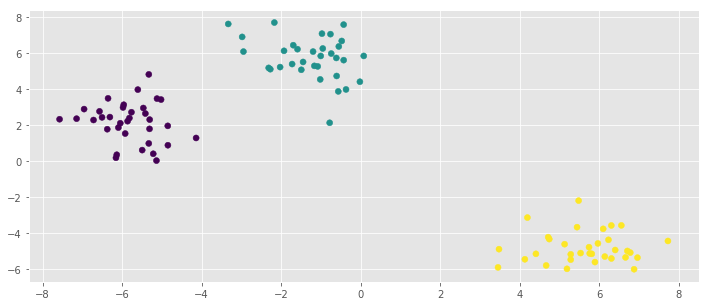

In [54]:
plt.scatter(X[:,0], X[:, 1], c=y)


Проверьте Вашу имплементацию на простых данных (без этого пункта задание не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

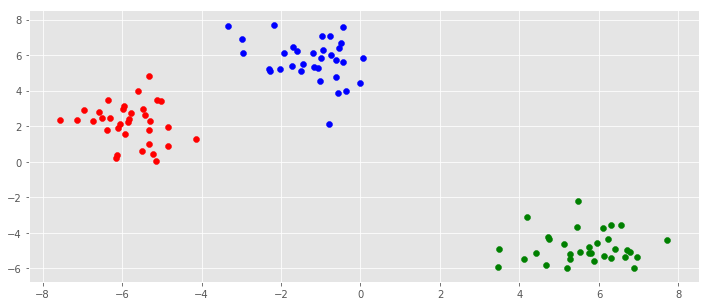

In [29]:
## Работоспособность KMeans

from sklearn.datasets import make_blobs
import matplotlib
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
               center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
model = Kmeans()
model = model.fit(X)
plt.scatter(X[model.labels==0,0],X[model.labels==0,1], c='r' )
plt.scatter(X[model.labels==1,0],X[model.labels==1,1], c='g' )
plt.scatter(X[model.labels==2,0],X[model.labels==2,1], c='b' )

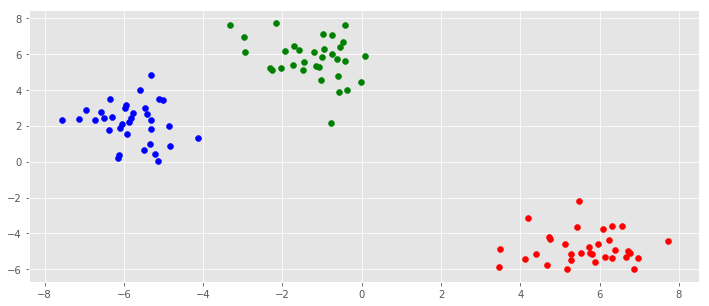

In [30]:
## Работоспособность KMeans++
from sklearn.datasets import make_blobs
import matplotlib
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
modelplus = Kmeans(init='k-means')
result = modelplus.fit(X)
plt.scatter(X[result.labels==0,0],X[result.labels==0,1], c='r' )
plt.scatter(X[result.labels==1,0],X[result.labels==1,1], c='g' )
plt.scatter(X[result.labels==2,0],X[result.labels==2,1], c='b' )

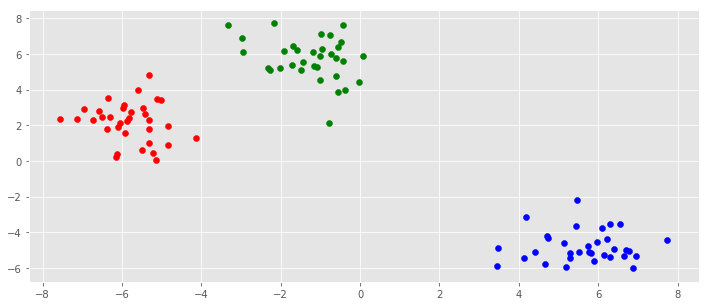

In [31]:
## Работоспособность KMeans с MiniBatchKMeans
from sklearn.datasets import make_blobs
import matplotlib
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
model_mini_batch = MiniBatchKMeans()
model_mini_batch.init_mini_batch(X,b=10)
result = model_mini_batch.miniBatchFit(X)
plt.scatter(X[result.labels==0,0],X[result.labels==0,1], c='r' )
plt.scatter(X[result.labels==1,0],X[result.labels==1,1], c='g' )
plt.scatter(X[result.labels==2,0],X[result.labels==2,1], c='b' )

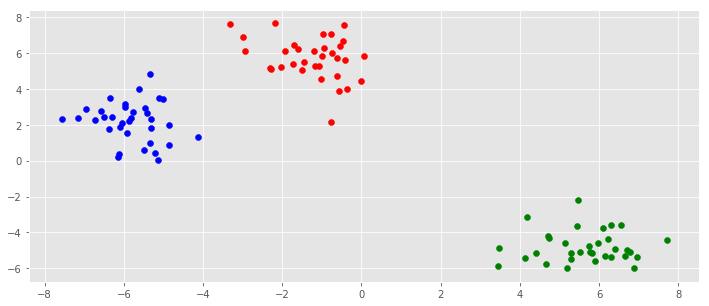

In [32]:
## Работоспособность KMeans++ с MiniBatchKMeans
from sklearn.datasets import make_blobs
import matplotlib
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
model_mini_batch = MiniBatchKMeans(init='k-means')
model_mini_batch.init_mini_batch(X,b=10)
result = model_mini_batch.miniBatchFit(X)
plt.scatter(X[result.labels==0,0],X[result.labels==0,1], c='r' )
plt.scatter(X[result.labels==1,0],X[result.labels==1,1], c='g' )
plt.scatter(X[result.labels==2,0],X[result.labels==2,1], c='b' )

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice.


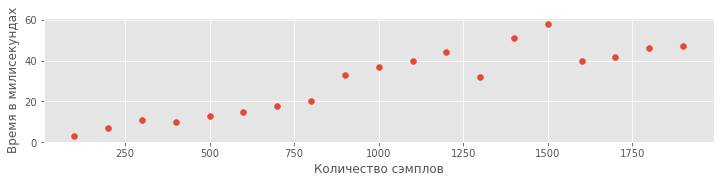

In [34]:
## Время выполнения алгоритма KMeans
%matplotlib inline
from time import time
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)
num_samles = np.arange(100,2000,100)
time_samples = np.zeros(num_samles.shape)
t = 10
ind = 0
for n in num_samles:
    X, y = make_blobs(n_samples=n, n_features=2, centers=3, cluster_std=1, 
               center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    model = Kmeans()
    times = np.zeros(t)
    for i in xrange(t):
        tic = time()
        model = model.fit(X)
        toc = time()
        times[i] = toc - tic    
    time_samples[ind] = times.min()
    ind += 1
fig = plt.figure()
ax = fig.add_subplot(211)
ax.scatter(num_samles,time_samples*1000)
ax.yaxis.set_label_position('left')
ax.set_ylabel(u'Время в милисекундах')
ax.xaxis.set_label_position('bottom')
ax.set_xlabel(u'Количество сэмплов')


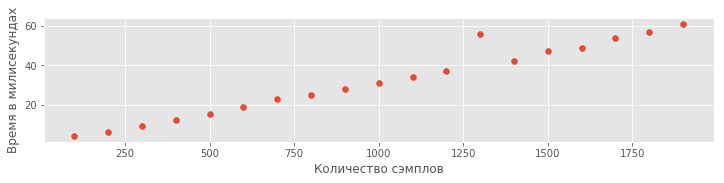

In [23]:
## Время выполнения алгоритма KMeans++
%matplotlib inline
from time import time
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)
num_samles = np.arange(100,2000,100)
time_samples = np.zeros(num_samles.shape)
t = 10
ind = 0
for n in num_samles:
    X, y = make_blobs(n_samples=n, n_features=2, centers=3, cluster_std=1, 
               center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    model = Kmeans(init='k-means')
    times = np.zeros(t)
    for i in xrange(t):
        tic = time()
        model = model.fit(X)
        toc = time()
        times[i] = toc - tic    
    time_samples[ind] = times.min()
    ind += 1
fig = plt.figure()
ax = fig.add_subplot(211)
ax.scatter(num_samles,time_samples*1000)
ax.yaxis.set_label_position('left')
ax.set_ylabel(u'Время в милисекундах')
ax.xaxis.set_label_position('bottom')
ax.set_xlabel(u'Количество сэмплов')

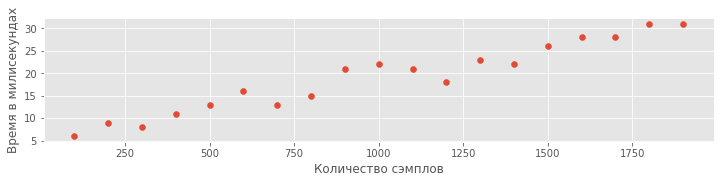

In [22]:
## Время выполнения алгоритма KMeans с MiniBatchKMeans
%matplotlib inline
from time import time
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)
num_samles = np.arange(100,2000,100)
time_samples = np.zeros(num_samles.shape)
t = 10
ind = 0
for n in num_samles:
    X, y = make_blobs(n_samples=n, n_features=2, centers=3, cluster_std=1, 
               center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    model_mini_batch = MiniBatchKMeans()
    model_mini_batch.init_mini_batch(X,b=10)
    times = np.zeros(t)
    for i in xrange(t):
        tic = time()
        model_mini_batch = model_mini_batch.miniBatchFit(X)
        toc = time()
        times[i] = toc - tic    
    time_samples[ind] = times.min()
    ind += 1
fig = plt.figure()
ax = fig.add_subplot(211)
ax.scatter(num_samles,time_samples*1000)
ax.yaxis.set_label_position('left')
ax.set_ylabel(u'Время в милисекундах')
ax.xaxis.set_label_position('bottom')
ax.set_xlabel(u'Количество сэмплов')


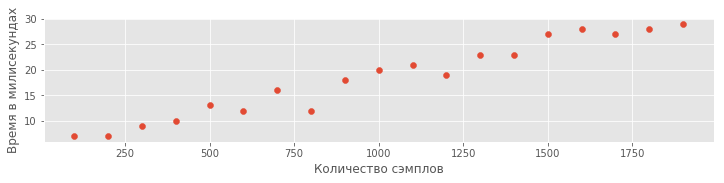

In [21]:
## Время выполнения алгоритма  KMeans++ с MiniBatchKMeans
%matplotlib inline
from time import time
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)
num_samles = np.arange(100,2000,100)
time_samples = np.zeros(num_samles.shape)
t = 10
ind = 0
for n in num_samles:
    X, y = make_blobs(n_samples=n, n_features=2, centers=3, cluster_std=1, 
               center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    model_mini_batch = MiniBatchKMeans(init='k-means')
    model_mini_batch.init_mini_batch(X,b=10)
    times = np.zeros(t)
    for i in xrange(t):
        tic = time()
        model_mini_batch = model_mini_batch.miniBatchFit(X)
        toc = time()
        times[i] = toc - tic    
    time_samples[ind] = times.min()
    ind += 1
fig = plt.figure()
ax = fig.add_subplot(211)
ax.scatter(num_samles,time_samples*1000)
ax.yaxis.set_label_position('left')
ax.set_ylabel(u'Время в милисекундах')
ax.xaxis.set_label_position('bottom')
ax.set_xlabel(u'Количество сэмплов')

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [3]:
## KMeans
import pandas as pd
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns = df_sns.drop(['gradyear', 'gender','age','friends'],axis=1)
X = df_sns.iloc[:,1:].values
X = (X - X.mean(axis=0)) / X.std(axis=0)
model = Kmeans(k=9, max_iter=1000,eps=0.1)
model.fit(X)
df_sns.loc[:,'labels'] = model.predict(X)
print df_sns.groupby('labels').agg('mean').transpose()

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice.
D:\Anaconda\lib\site-packages\numpy\core\_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


labels               0         1         2         3         4         5  \
basketball    0.187354  0.880597  0.540193  0.177097  0.387037  0.354528   
football      0.152202  1.171642  0.504823  0.282290  0.374074  0.300578   
soccer        0.131461  0.427239  0.331190  0.163782  0.250000  0.219653   
softball      0.073389  0.319030  0.287245  0.158455  0.225926  0.179191   
volleyball    0.064508  0.218284  0.213290  0.089214  0.209259  0.138728   
swimming      0.062540  0.179104  0.272240  0.145140  0.157407  0.175337   
cheerleading  0.040949  0.233209  0.197213  0.050599  0.164815  0.109827   
baseball      0.034833  3.063433  0.178992  0.046605  0.072222  0.088632   
tennis        0.058977  0.110075  0.153269  0.090546  0.133333  0.105973   
sports        0.088970  0.472015  0.553055  0.095872  0.124074  0.131021   
cute          0.152999  0.488806  0.700965  0.272969  0.694444  0.300578   
sex           0.090725  0.320896  2.619507  0.151798  0.231481  0.196532   
sexy        

In [6]:
## KMeans++
import pandas as pd
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns = df_sns.drop(['gradyear', 'gender','age','friends'],axis=1)
X = df_sns.iloc[:,1:].values
X = (X - X.mean(axis=0)) / X.std(axis=0)
modelplus = Kmeans(k=9, max_iter=1000,init='k-means',eps=0.1)
modelplus.fit(X)

df_sns.loc[:,'labels'] = modelplus.predict(X)
print df_sns.groupby('labels').agg('mean').transpose()

labels               0      1      2         3         4     5         6  \
basketball    0.187172    0.0    0.0  0.390424  1.076190   0.0  0.363091   
football      0.146571    2.0    0.0  0.270718  1.033333   1.0  0.332333   
soccer        0.136645    0.0    0.0  0.243094  0.585714   1.0  0.264066   
softball      0.078886    0.0    0.0  0.163904  0.495238   0.0  0.206302   
volleyball    0.070993    0.0    0.0  0.167587  0.328571   0.0  0.147787   
swimming      0.074727    1.0    0.0  0.180479  0.452381  31.0  0.195799   
cheerleading  0.044855    0.0    0.0  0.103131  0.357143   0.0  0.138035   
baseball      0.057522    0.0    0.0  0.127072  0.485714   0.0  0.137284   
tennis        0.058420    0.0    0.0  0.108656  0.323810   0.0  0.085521   
sports        0.084700    0.0    0.0  0.151013  1.076190   1.0  0.320330   
cute          0.157064    1.0    0.0  0.313076  1.338095   0.0  0.477119   
sex           0.092026   22.0  114.0  0.211786  4.647619   0.0  1.358590   
sexy        

In [4]:
## KMeans с MiniBatchKMeans
import pandas as pd
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns = df_sns.drop(['gradyear', 'gender','age','friends'],axis=1)
X = df_sns.iloc[:,1:].values
X = (X - X.mean(axis=0)) / X.std(axis=0)
model_mini_batch = MiniBatchKMeans(k=9,max_iter=1000,eps=0.1)
model_mini_batch.init_mini_batch(X,b=100)
model_mini_batch.miniBatchFit(X)
df_sns.loc[:,'labels'] = model_mini_batch.predict(X)
print df_sns.groupby('labels').agg('mean').transpose()

labels               0         1         2         3         4         5  \
basketball    0.785244  0.307692  0.401575  0.370682  0.459751  0.314565   
football      1.238472  0.372080  0.505512  0.381634  0.429705  0.290086   
soccer        0.476943  0.234758  0.240945  0.360573  0.434807  0.222766   
softball      0.221344  0.111681  0.182677  0.136479  0.157596  0.108935   
volleyball    0.255599  0.135613  0.206299  0.303286  0.197279  0.156671   
swimming      0.739130  0.170940  0.166929  0.253580  0.246032  0.160343   
cheerleading  0.102767  0.054701  2.943307  0.179444  0.101474  0.042840   
baseball      2.304348  0.046724  0.143307  0.085931  0.137188  0.079559   
tennis        0.094862  0.113960  0.072441  0.171019  0.143424  0.166463   
sports        0.507246  0.112251  0.144882  0.163437  0.399660  0.146879   
cute          0.445323  0.646724  0.524409  0.629318  0.943311  0.337821   
sex           0.251647  0.157835  0.214173  0.192081  1.659864  0.148103   
sexy        

In [5]:
## KMeans++ с MiniBatchKMeans
import pandas as pd
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns = df_sns.drop(['gradyear', 'gender','age','friends'],axis=1)
X = df_sns.iloc[:,1:].values
X = (X - X.mean(axis=0)) / X.std(axis=0)
model_mini_batch = MiniBatchKMeans(k=9,max_iter=1000,init='k-means',eps=0.1)
model_mini_batch.init_mini_batch(X,b=100)
model_mini_batch.miniBatchFit(X)
df_sns.loc[:,'labels'] = model_mini_batch.predict(X)
print df_sns.groupby('labels').agg('mean').transpose()

labels               0      1         2     3     4     5         6         7  \
basketball    0.228852    0.0  0.573620   0.0   1.5   0.0  0.912500  0.628821   
football      0.208593    2.0  0.612621   1.0   7.0   0.0  0.950000  0.585153   
soccer        0.202704    0.0  0.425066   1.0   1.0   0.0  0.275000  0.338428   
softball      0.141296    0.0  0.351884   0.0   1.0   0.0  0.300000  0.290393   
volleyball    0.091667    0.0  0.740578   0.0   0.0   0.0  0.112500  0.209607   
swimming      0.116741    1.0  0.294917  31.0   0.5   0.0  0.150000  0.290393   
cheerleading  0.082741    0.0  0.366345   0.0   4.0   0.0  0.095833  0.189956   
baseball      0.058148    0.0  0.169588   0.0   2.0   0.0  4.445833  0.231441   
tennis        0.080444    0.0  0.147677   0.0   0.5   0.0  0.058333  0.198690   
sports        0.115185    0.0  0.265557   1.0   5.0   0.0  0.466667  0.569869   
cute          0.248407    1.0  1.101665   0.0   6.0   0.0  0.266667  0.831878   
sex           0.131889   22.

In [ ]:
## Вывод
''''
1) Из п. 4 стало понятно, что алгоритм K-means miniBatch работал быстрее всего (видно после замеров времени выполнения)
Это связано с тем, что на каждой итерации в вызове 
C = np.array([np.argmin([np.dot(x - cent, x - cent) for cent in self.centroids]) for x in X])
в качестве Х была небольшая подвыборка. Опытным путем было установлено, что этот и тоько этот вызов(кроме инициализации, а
о ней ниже) влиял на скорость выполнение алгоритма.
2) По описаию алгоритма miniBatch видно, что он никак не влияет на качество результата. Только на скорость.
3) Сравнение k-means и k-means++. С точки зрения времени работы, ++ выполнялся дольше из-за инициализации, т.к в обычном
k-means мы тупо рандомим один вектор и все. Что касается качества, то из распечаток выше видно, что с ++ деление происходило
немного по-другому. Появились кластеры, в которых очень много средних значений = 0. Это связано с "более правильной и 
логичной" инициализации начальных центроид. В результате были получены кластеры, в которых достаточно мало объектов,
однако они все практически идентичны. Достоинство это или недостаток - зависит от поставленной задачи. Если требуется выделить
"сильно отличающиеся" ото всех остальных объекты (как например объект, у которого поле Blonde много больше среднего остальных. 
Опять же это видно в распечатках выше), то данная модификация уместна. Так же было установлено (в 4 пункте задания), что при
многократном запуске обычного k-means, могли получатся разные результаты, порой не совсем верные. Это связано с рандомной
инициализацией начальных центроид.
4) Вывод. k-means++ работает более стабильно и предсказуемо, не давая в общем случае прирост скорости,
k-means miniBatch дает значительный (зависит от размера подвыборки) прирост скорости, однако не дает никакого,
в общем случае, улучшения результата.
P.S на выполнение алгоритмов с реальными данными порой уходило около минуты.  В среднем 30-40 секунд. Программы не зависают,
надо просто немного подождать)
''''